In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
from os.path import join
import os
import json

In [35]:
def remove_zero_sum_cols(df):
    sum_series = df.sum(axis=0)
    nonzero_sum_cols = sum_series[sum_series > 0].index.values.tolist()
    df = df[nonzero_sum_cols]
    return df

In [36]:
def normalize_df(df):
    return pd.DataFrame(
        index=df.index.values.tolist(),
        columns=df.columns.values.tolist(),
        data=(df.values / df.values.sum(axis=0, keepdims=True))
    )

In [37]:
DATA_DIR = "data"
TSF_WINDOW_DIR = join(DATA_DIR, "cis-pd", "training_data_tsf_sample")
TSF_WINDOW_FILES = [ join(TSF_WINDOW_DIR, f) for f in os.listdir(TSF_WINDOW_DIR) if f.endswith(".tsf.csv") ]

In [38]:
len(TSF_WINDOW_FILES)

327

### Analysis of a single tsfresh extract_features file

In [128]:
f = TSF_WINDOW_FILES[9]
df = pd.read_csv(f, index_col=0)

In [129]:
non_fft_cols = [ c for c in df.columns.values.tolist() if not c.startswith("value__fft") ]

In [130]:
var_df = pd.DataFrame(data=[], columns=["variable", "variance", "dim"], index=[])
for dim, dim_df in df.groupby("id"):
    dim_df = dim_df.drop(columns=["id", "window_stop", "window_count"])
    dim_df = dim_df.set_index("window_start", drop=True)
    dim_df = remove_zero_sum_cols(dim_df)
    dim_df = normalize_df(dim_df)
    
    dim_var_df = dim_df.var().to_frame().reset_index().rename(columns={'index': 'variable', 0: 'variance'})
    dim_var_df = dim_var_df.loc[dim_var_df["variable"].isin(non_fft_cols)]
    dim_var_df = dim_var_df.sort_values(by="variance", ascending=False)
    dim_var_df = dim_var_df.loc[dim_var_df["variance"] <= 10]
    dim_var_df = dim_var_df.loc[dim_var_df["variance"] > 0.1]
    dim_var_df["dim"] = dim
    var_df = var_df.append(dim_var_df, ignore_index=True)

var_variables = var_df["variable"].unique().tolist()
var_df.head()

,variable,variance,dim
0,value__mean_change,1.310279,X
1,"value__change_quantiles__f_agg_""mean""__isabs_F...",1.310279,X
2,"value__agg_linear_trend__f_agg_""var""__chunk_le...",0.367492,X
3,"value__cwt_coefficients__widths_(2, 5, 10, 20)...",0.238520,X
4,"value__change_quantiles__f_agg_""mean""__isabs_F...",0.112793,X


### Plot of variance for each non-FFT feature, faceted by dimension

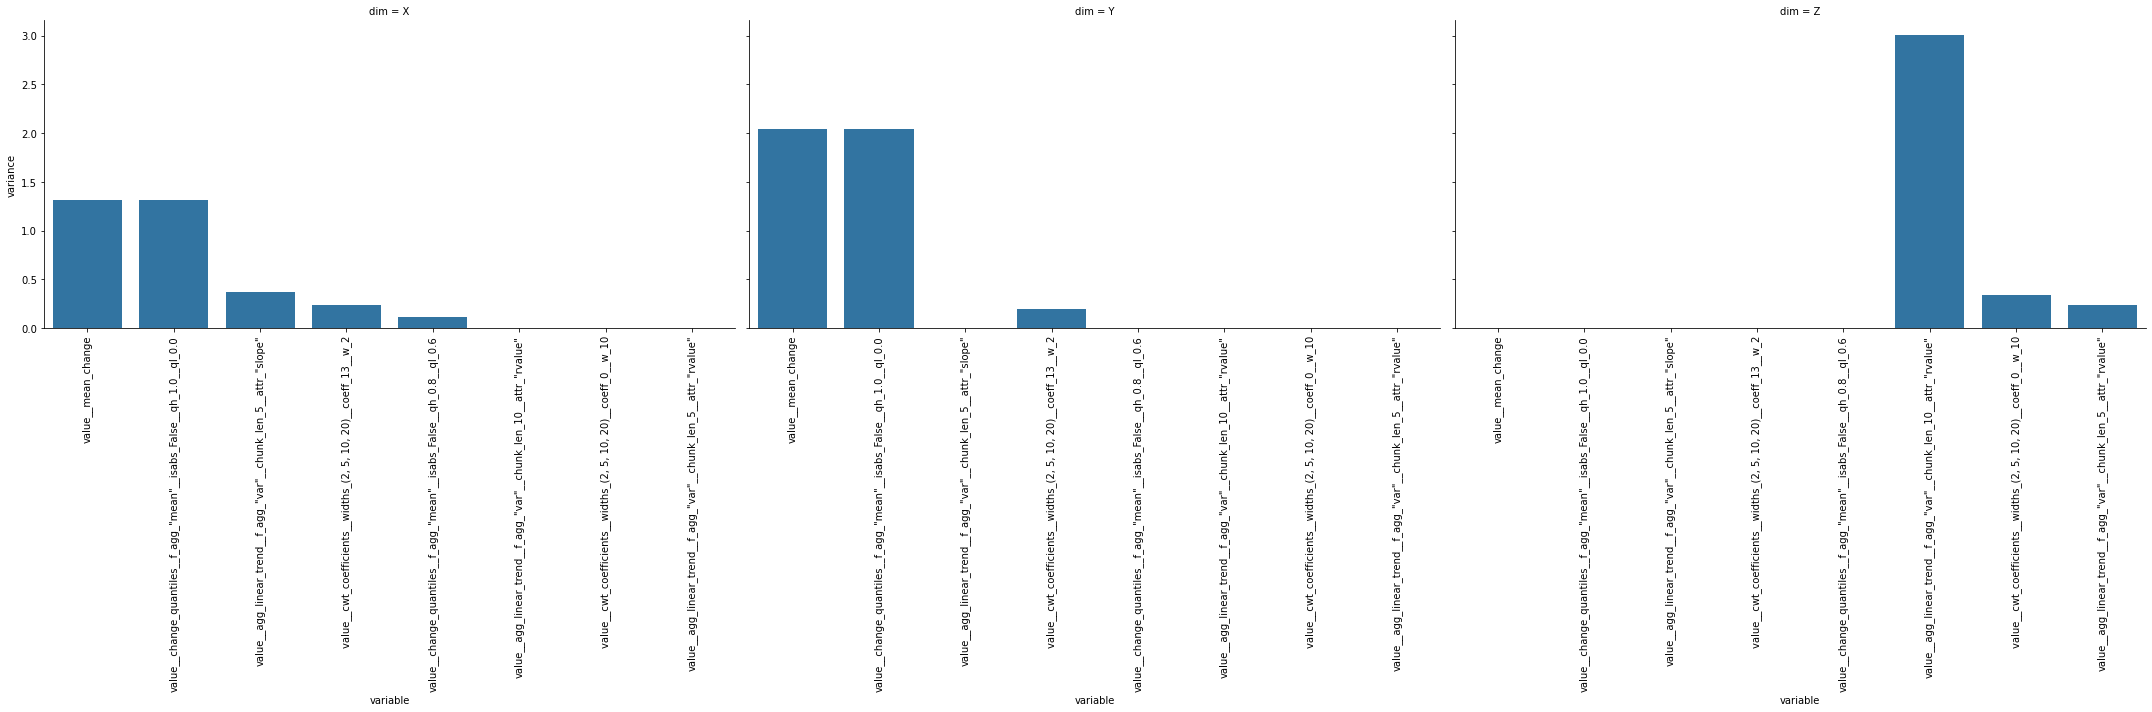

In [131]:
g = sns.FacetGrid(var_df, col="dim", height=10, aspect=1)
g.set_xticklabels(rotation=90)
g.map(sns.barplot, 'variable', 'variance', order=var_variables)

In [132]:
ent_df = pd.DataFrame(data=[], columns=["variable", "entropy", "dim"], index=[])
for dim, dim_df in df.groupby("id"):
    dim_df = dim_df.drop(columns=["id", "window_stop", "window_count"])
    dim_df = dim_df.set_index("window_start", drop=True)
    dim_df = remove_zero_sum_cols(dim_df)
    dim_entropies = []
    for col_i, col_name in enumerate(dim_df.columns.values.tolist()):
        dim_entropies.append({
            "variable": col_name,
            "entropy": scipy.stats.entropy(dim_df.values[:,col_i], base=2)
        })
    dim_ent_df = pd.DataFrame(data=dim_entropies)
    dim_ent_df = dim_ent_df.loc[dim_ent_df["variable"].isin(non_fft_cols)]
    dim_ent_df = dim_ent_df.loc[dim_ent_df["entropy"] <= 6]
    dim_ent_df = dim_ent_df.loc[dim_ent_df["entropy"] > 0]
    dim_ent_df = dim_ent_df.sort_values(by="entropy", ascending=False)
    dim_ent_df["dim"] = dim
    ent_df = ent_df.append(dim_ent_df, ignore_index=True)

ent_variables = ent_df["variable"].unique().tolist()
ent_df.head()

,variable,entropy,dim
0,"value__change_quantiles__f_agg_""var""__isabs_Tr...",5.865617,X
1,value__large_standard_deviation__r_0.25,5.614710,X
2,value__number_crossing_m__m_-1,5.358947,X
3,value__value_count__value_0,5.194236,X
4,value__number_crossing_m__m_1,4.689368,X


### Plot of entropy for each feature, faceted by dimension

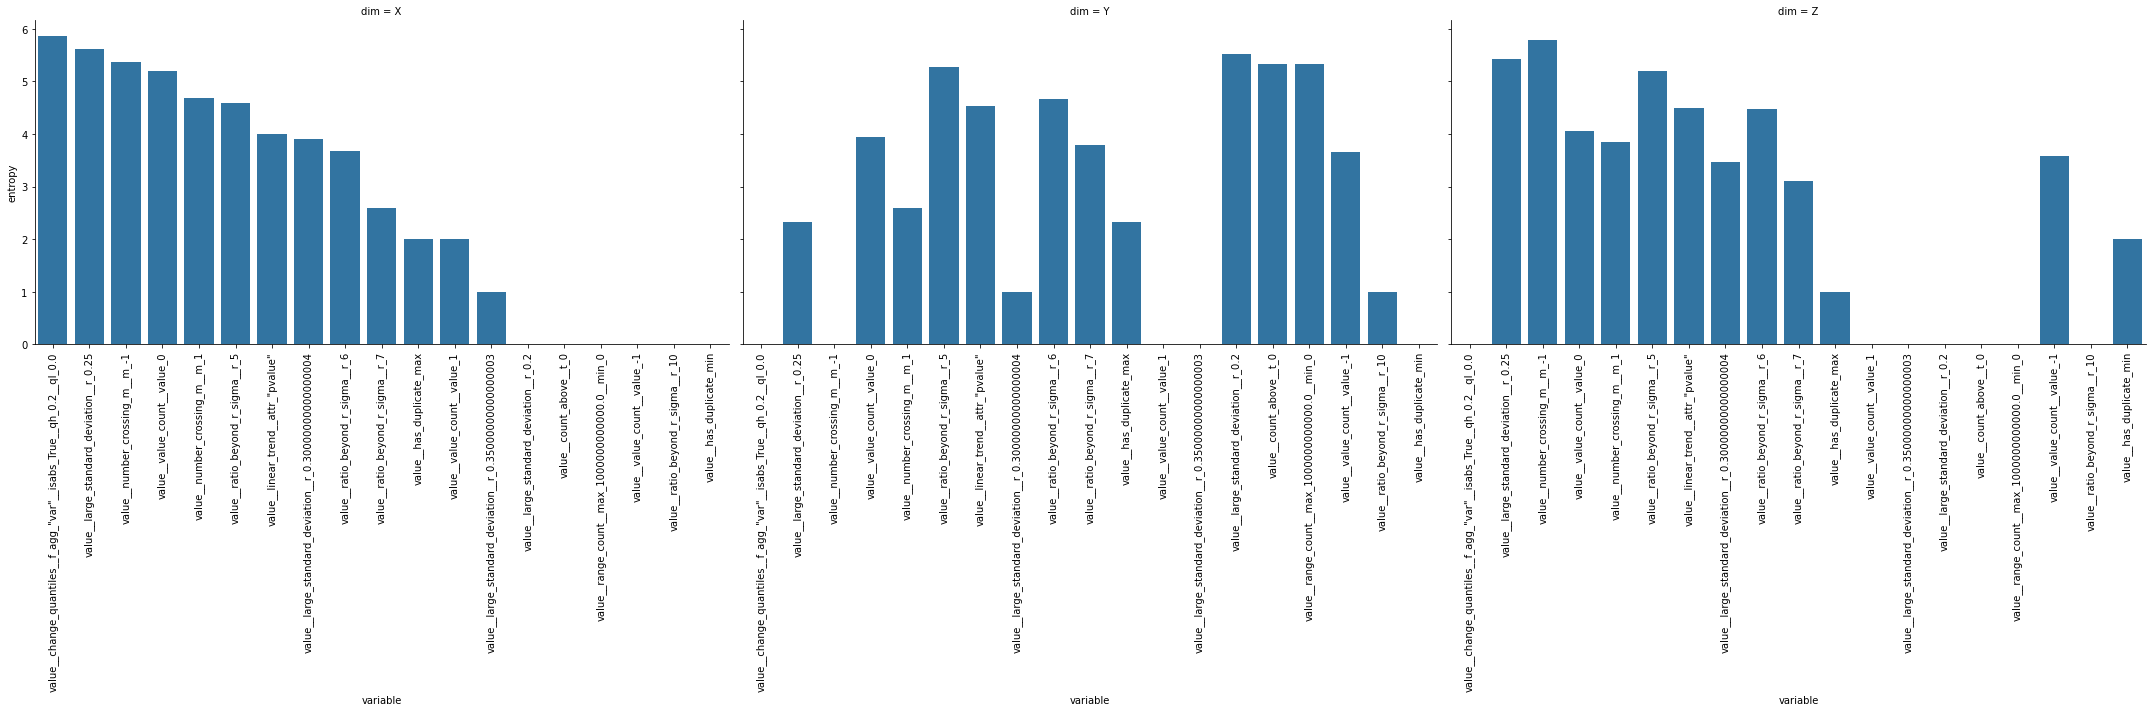

In [133]:
g = sns.FacetGrid(ent_df, col="dim", height=10, aspect=1)
g.set_xticklabels(rotation=90)
g.map(sns.barplot, 'variable', 'entropy', order=ent_variables)

In [134]:
print(len(var_variables))
print(len(ent_variables))
intersect_variables = set(var_variables).union(set(ent_variables))
len(intersect_variables)

8
19


27

In [135]:
nonsense_variables = {
    "value__count_below__t_0",
    "value__count_above__t_0",
    "value__has_duplicate_min",
    "value__has_duplicate_max",
    "value__value_count__value_-1",
    "value__value_count__value_0",
    "value__value_count__value_1",
    "value__number_crossing_m__m_-1",
    "value__number_crossing_m__m_0",
    "value__number_crossing_m__m_1"
}

In [136]:
good_variables = list(intersect_variables.difference(nonsense_variables))
good_variables

['value__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"slope"',
 'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10',
 'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_13__w_2',
 'value__large_standard_deviation__r_0.2',
 'value__ratio_beyond_r_sigma__r_7',
 'value__linear_trend__attr_"pvalue"',
 'value__ratio_beyond_r_sigma__r_6',
 'value__mean_change',
 'value__agg_linear_trend__f_agg_"var"__chunk_len_10__attr_"rvalue"',
 'value__large_standard_deviation__r_0.25',
 'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0',
 'value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0',
 'value__large_standard_deviation__r_0.30000000000000004',
 'value__large_standard_deviation__r_0.35000000000000003',
 'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6',
 'value__range_count__max_1000000000000.0__min_0',
 'value__ratio_beyond_r_sigma__r_10',
 'value__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"rvalue"',
 'value__ratio_beyon

In [118]:
with open(join(DATA_DIR, "tsf_window_variables.json"), "w") as f:
    json.dump(good_variables, f)